In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets

## 卷积神经网络(进阶)

### Inception Module

在一个module中, 通过不同的branch, 实现不同尺度的特征提取.

- What is 1x1 convolution?
  - 起到"信息融合"的作用

In [2]:
class InceptionA(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.branch1x1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)

        self.branch5x5_1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5x5_2 = torch.nn.Conv2d(16, 24, kernel_size=5, padding=2)

        self.branch3x3_1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3_2 = torch.nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch3x3_3 = torch.nn.Conv2d(24, 24, kernel_size=3, padding=1)

        self.branch_pool = torch.nn.Conv2d(in_channels, 24, kernel_size=1)

    def forward(self, x):
        # Branch: 1x1 conv
        branch1x1 = self.branch1x1(x)

        # Branch: 1x1 conv -> 5x5 conv
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        # Branch: 1x1 conv -> 3x3 conv -> 3x3 conv
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch3x3 = self.branch3x3_3(branch3x3)

        # Branch: avg-pooling -> 1x1 conv
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3, branch_pool]
        return torch.cat(outputs, 1)
    
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, 5)
        self.conv2 = torch.nn.Conv2d(88, 20, 5)

        self.incep1 = InceptionA(10)
        self.incep2 = InceptionA(20)

        self.mp = torch.nn.MaxPool2d(2)
        self.fc = torch.nn.Linear(1408, 10)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = self.incep1(x)
        x = F.relu(self.mp(self.conv2(x)))
        x = self.incep2(x)
        x = x.view(in_size, -1)
        x = self.fc(x)
        return x

## Test the Model

In [3]:
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),                      # Convert PIL image to PyTorch Tensor.
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize using the mean value and std loss value
])

train_dataset = datasets.MNIST(root='./dataset/mnist', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./dataset/mnist', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model = Net()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(epoch: int):
    running_loss = 0.0
    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 100 == 99:
            print(f'[{epoch + 1}, {batch_idx + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for (images, labels) in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy on test set: {100 * correct / total: .4f}%')
    return 100 * correct / total

[1,   100] loss: 1.557
[1,   200] loss: 0.452
[1,   300] loss: 0.300
[1,   400] loss: 0.235
[1,   500] loss: 0.182
[1,   600] loss: 0.165
[1,   700] loss: 0.163
[1,   800] loss: 0.115
[1,   900] loss: 0.126
Accuracy on test set:  96.8700%
[2,   100] loss: 0.117
[2,   200] loss: 0.112
[2,   300] loss: 0.106
[2,   400] loss: 0.105
[2,   500] loss: 0.096
[2,   600] loss: 0.104
[2,   700] loss: 0.084
[2,   800] loss: 0.097
[2,   900] loss: 0.092
Accuracy on test set:  97.6900%
[3,   100] loss: 0.074
[3,   200] loss: 0.071
[3,   300] loss: 0.083
[3,   400] loss: 0.085
[3,   500] loss: 0.084
[3,   600] loss: 0.074
[3,   700] loss: 0.070
[3,   800] loss: 0.080
[3,   900] loss: 0.074
Accuracy on test set:  98.1600%
[4,   100] loss: 0.073
[4,   200] loss: 0.069
[4,   300] loss: 0.061
[4,   400] loss: 0.067
[4,   500] loss: 0.061
[4,   600] loss: 0.059
[4,   700] loss: 0.070
[4,   800] loss: 0.059
[4,   900] loss: 0.066
Accuracy on test set:  98.4500%
[5,   100] loss: 0.052
[5,   200] loss: 0.05

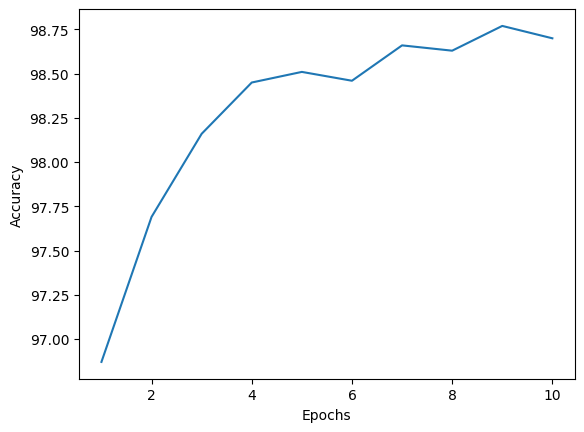

In [4]:
epochs = []
accuracies = []

if __name__ == '__main__':
    for epoch in range(10):
        train(epoch)
        epochs.append(epoch + 1)
        accuracies.append(test())
    plt.plot(epochs, accuracies)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

## Residual Network

### 实现 ResBlock

In [5]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.conv1 = torch.nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        return F.relu(x + y)
    
class Net(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5)
        self.mp = torch.nn.MaxPool2d(2)

        self.rblock1 = ResidualBlock(16)
        self.rblock2 = ResidualBlock(32)

        self.fc = torch.nn.Linear(512, 10)

    def forward(self, x):
        in_size = x.size(0)
        x = self.mp(F.relu(self.conv1(x)))
        x = self.rblock1(x)
        x = self.mp(F.relu(self.conv2(x)))
        x = self.rblock2(x)
        x = x.view(in_size, -1)
        x = self.fc(x)
        return x

## Test the Model

In [6]:
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),                      # Convert PIL image to PyTorch Tensor.
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize using the mean value and std loss value
])

train_dataset = datasets.MNIST(root='./dataset/mnist', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./dataset/mnist', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model = Net()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(epoch: int):
    running_loss = 0.0
    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 100 == 99:
            print(f'[{epoch + 1}, {batch_idx + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for (images, labels) in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy on test set: {100 * correct / total: .4f}%')
    return 100 * correct / total

[1,   100] loss: 1.052
[1,   200] loss: 0.305
[1,   300] loss: 0.232
[1,   400] loss: 0.188
[1,   500] loss: 0.149
[1,   600] loss: 0.140
[1,   700] loss: 0.139
[1,   800] loss: 0.114
[1,   900] loss: 0.106
Accuracy on test set:  97.2000%
[2,   100] loss: 0.101
[2,   200] loss: 0.098
[2,   300] loss: 0.081
[2,   400] loss: 0.077
[2,   500] loss: 0.090
[2,   600] loss: 0.078
[2,   700] loss: 0.073
[2,   800] loss: 0.079
[2,   900] loss: 0.076
Accuracy on test set:  98.0900%
[3,   100] loss: 0.069
[3,   200] loss: 0.065
[3,   300] loss: 0.059
[3,   400] loss: 0.062
[3,   500] loss: 0.059
[3,   600] loss: 0.062
[3,   700] loss: 0.064
[3,   800] loss: 0.052
[3,   900] loss: 0.056
Accuracy on test set:  98.1400%
[4,   100] loss: 0.045
[4,   200] loss: 0.045
[4,   300] loss: 0.053
[4,   400] loss: 0.059
[4,   500] loss: 0.049
[4,   600] loss: 0.049
[4,   700] loss: 0.047
[4,   800] loss: 0.046
[4,   900] loss: 0.044
Accuracy on test set:  98.7000%
[5,   100] loss: 0.049
[5,   200] loss: 0.04

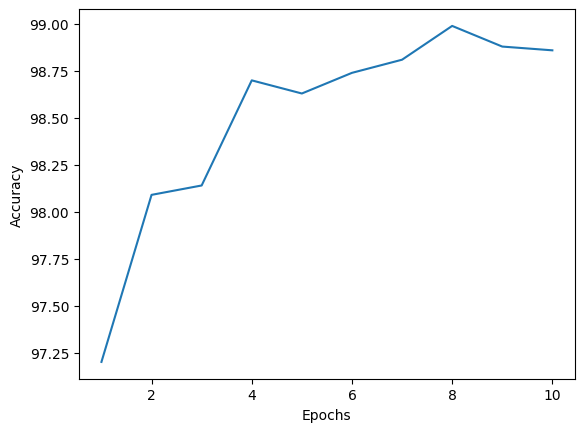

In [7]:
epochs = []
accuracies = []

if __name__ == '__main__':
    for epoch in range(10):
        train(epoch)
        epochs.append(epoch + 1)
        accuracies.append(test())
    plt.plot(epochs, accuracies)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

## 作业

- 阅读论文并实现: 
  - [He K, Zhang X, Ren S, et al. Identity Mappings in Deep Residual Networks[C].](https://link.springer.com/chapter/10.1007/978-3-319-46493-0_38)   [PDF ver.](https://arxiv.org/pdf/1603.05027.pdf)
- 阅读并实现 DenseNet: 
  - [Huang G, Liu Z, Van Der Maaten L, et al. Densely Connected Convolutional Networks[J].](https://arxiv.org/pdf/1608.06993v5.pdf) 

## 深入学习题外话

1. 理论 <深度学习> 花书
2. 阅读 Pytorch 文档
3. 复现经典工作
    - 跑代码 (会配环境)
    - 读代码 (理解别人思路)
    - 写代码 (复现)
4. 扩充视野